In [1]:
import numpy as np
import time
import cv2
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

## **YOLO Object Detection**

![](https://opencv-tutorial.readthedocs.io/en/latest/_images/yolo1_net.png)

**Steps Invovled**

1. Use Pretrained YOLOV3 weights (237MB)- https://pjreddie.com/media/files/yolov3.weights
2. Create our blob object which is our loaded model
3. Set the backend that runs the model

In [5]:
# COCO labels
labelPath = 'YOLO/yolo/coco.names'
LABELS = open(labelPath).read().strip().split('\n')
LABELS

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [9]:
# give random color for each label
COLOR = np.random.randint(0, 255, size=(len(LABELS), 3), dtype='uint8')
print('Loading YOLO weights....')

weights_path = "YOLO/yolo/yolov3.weights"
cfg_path = "YOLO/yolo/yolov3.cfg"

# Create blob object
net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)

# Set out backend
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
print("Our YOLO layers")
ln = net.getLayerNames()
print(len(ln), ln)

Loading YOLO weights....
Our YOLO layers
254 ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36

The input to the network is a called blob object.

The function ```cv.dnn.blobFromImage(img, scale, size, mean)``` transforms the image into a blob:

```blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)```

**It has the following parameters:**

1. the image to transform
2. the scale factor (1/255 to scale the pixel values to [0..1])
3. the size, here a 416x416 square image
4. the mean value (default=0)
5. the option swapBR=True (since OpenCV uses BGR)

**Note** A blob is a 4D numpy array object (images, channels, width, height). The image below shows the red channel of the blob. You notice the brightness of the red jacket in the background.

In [11]:
path = 'YOLO/images/'
filenames = [f for f in listdir(path) if isfile(join(path, f))]
filenames

['flowers.jpeg',
 'iceland_rum.jpeg',
 'tommys_beers.jpeg',
 'truck.jpg',
 'londonxmas2.jpeg',
 'coffee.jpg',
 'rot.jpg',
 'coffee_view.jpeg']

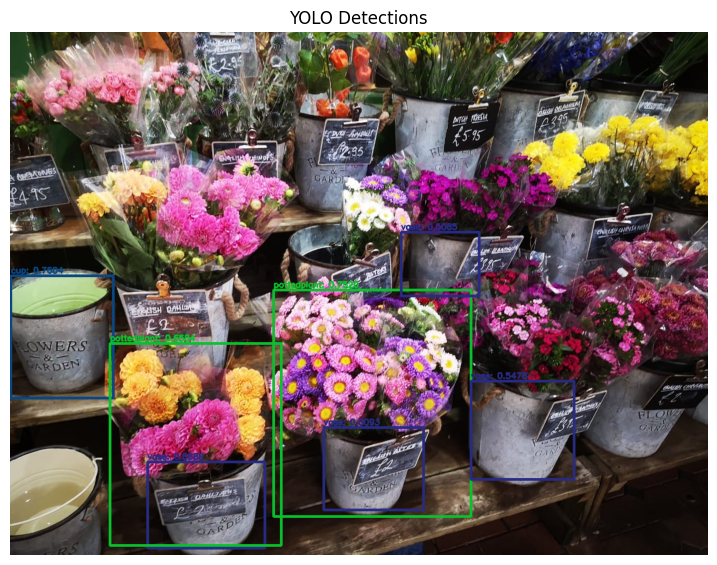

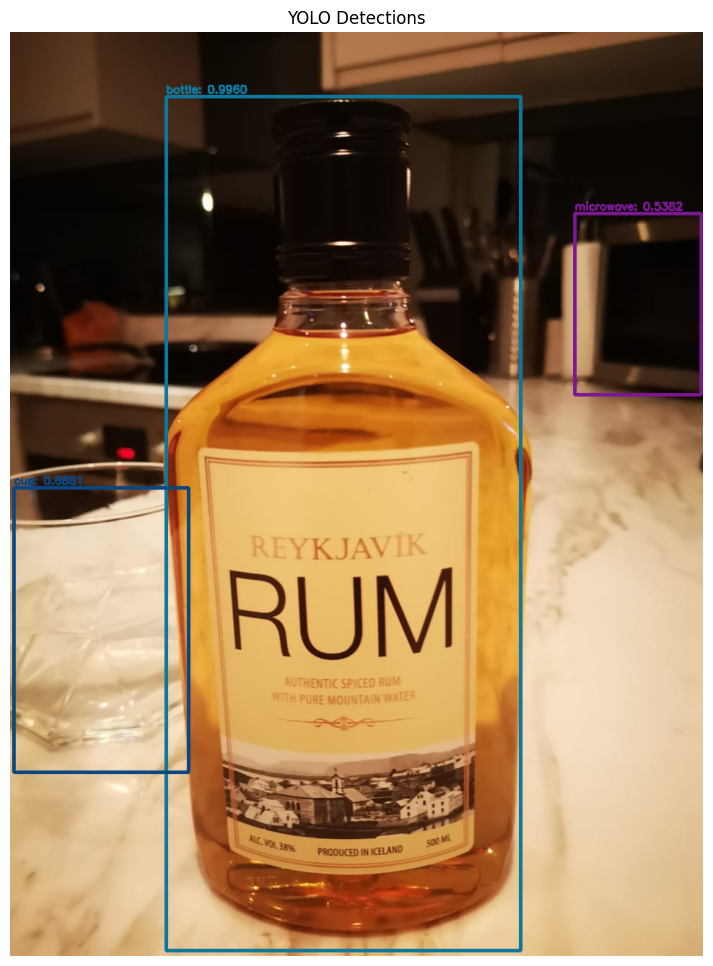

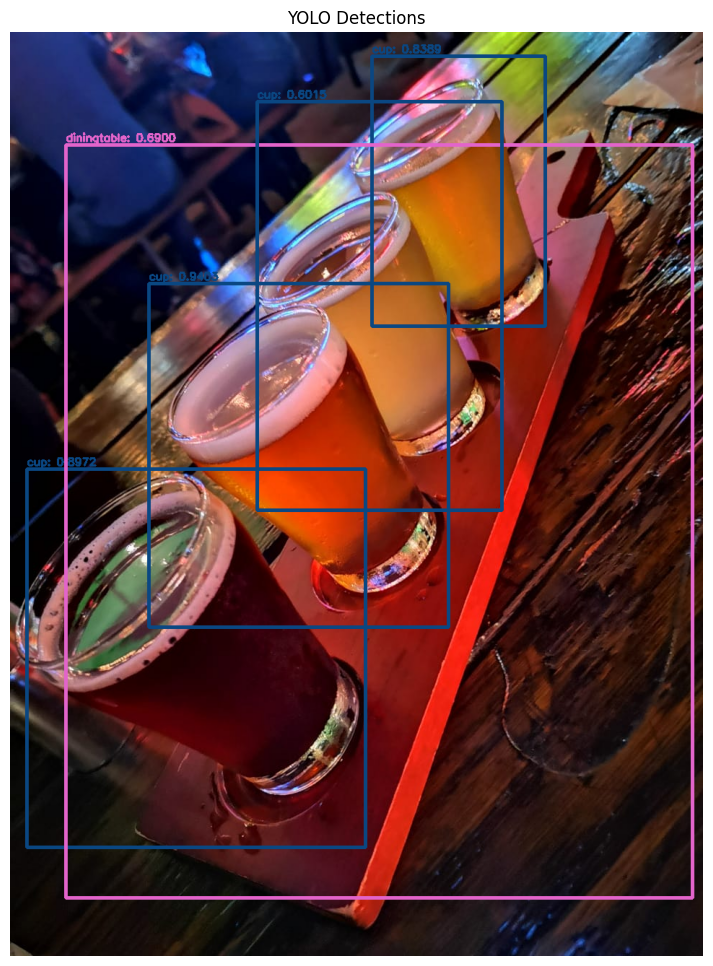

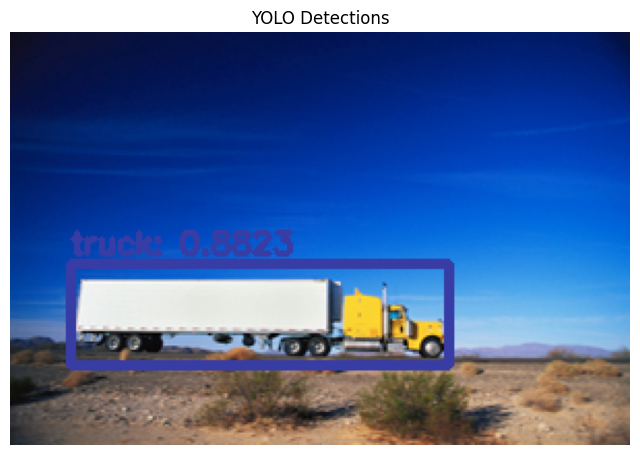

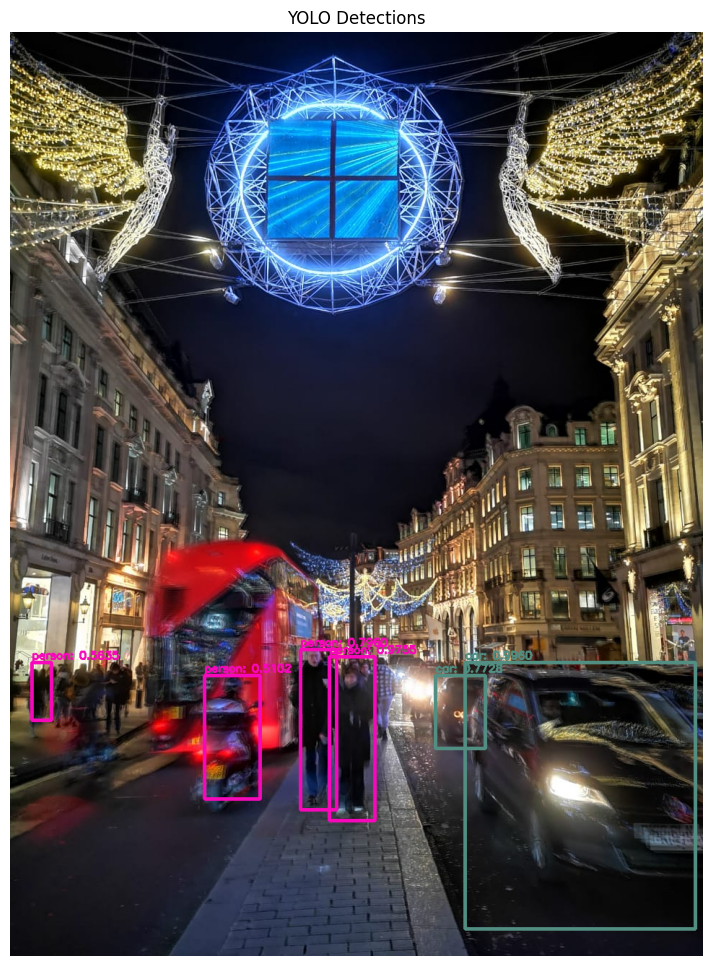

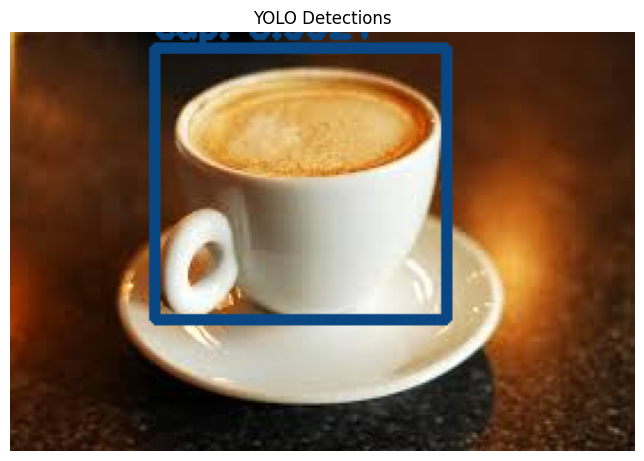

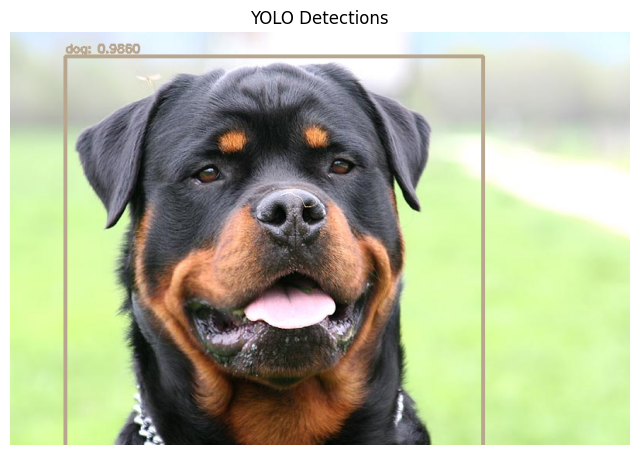

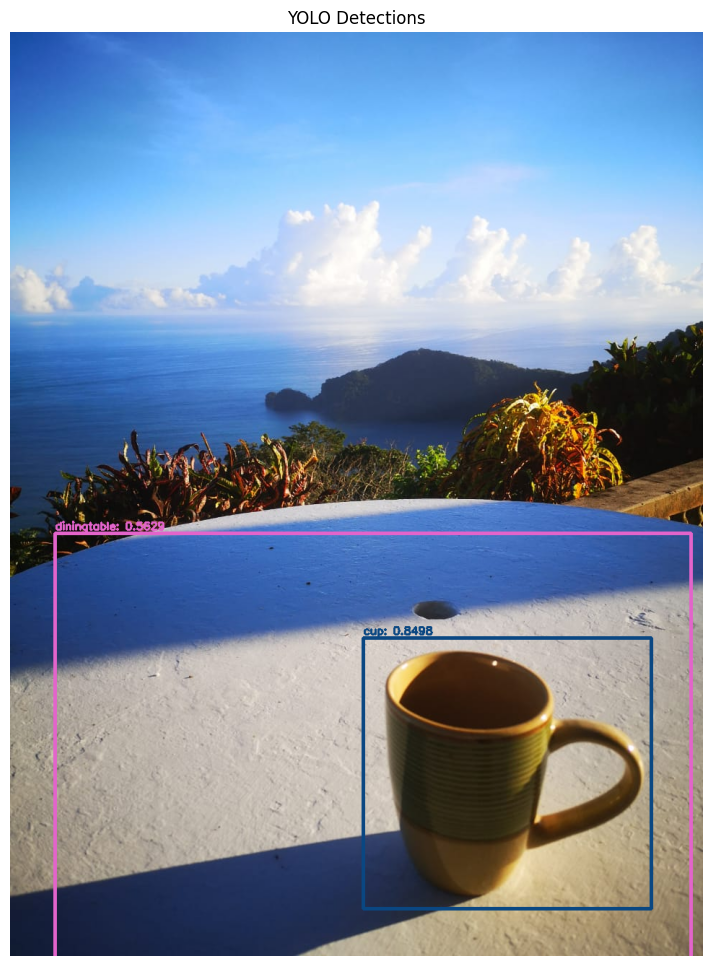

In [15]:
for file in filenames:
  image = cv2.imread(path+file) # get image
  (H, W) = image.shape[:2] # get height and weight

  # get output layer names
  ln = net.getLayerNames()
  ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

  blob = cv2.dnn.blobFromImage(image, 1/255.0, (256,256), swapRB=True, crop=False)
  # set our input to our image blob
  net.setInput(blob)
  # run a forward pass through the network
  layerOutputs = net.forward(ln)

  boxes = [] # detected bounding boxes
  confidences = [] # confidences
  ids = [] # classes
  # loop over each of the layer output
  for output in layerOutputs:
    # loop over each detection
    for detection in output:
      # get class id and probability
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]

      # keep only most probably predictions
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")

      # get the the top and left corner of the bounding box
      # remember we alredy have the width and height
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      # Append our list of bounding box coordinates, confidences and class IDs
      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      ids.append(classID)

# reduce overlapping
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

  if len(idxs) > 0:
        # iterate over the indexes we are keeping
        for i in idxs.flatten():
            # Get the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # Draw our bounding boxes and put our class label on the image
            color = [int(c) for c in COLOR[ids[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
            text = "{}: {:.4f}".format(LABELS[ids[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  imshow('YOLO Detections', image, size=12)

In [25]:
# Load class labels
with open('/content/YOLO/yolo/coco.names', 'r') as f:
    classes = f.read().splitlines()

# Open a video file
video_file = 'video.mp4'
cap = cv2.VideoCapture(video_file)

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# Get the video frame width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create video writer object to save the output
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (frame_width, frame_height))

# Get output layer names
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    (H, W) = frame.shape[:2]

    # Create a blob from the frame
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (256, 256), swapRB=True, crop=False)

    # Set input to the network
    net.setInput(blob)

    # Run a forward pass through the network
    layerOutputs = net.forward(ln)

    boxes = []  # Detected bounding boxes
    confidences = []  # Confidences
    ids = []  # Classes

    # Loop over each of the layer output
    for output in layerOutputs:
        # Loop over each detection
        for detection in output:
            # Get class id and probability
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Keep only most probable predictions
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # Get the top-left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # Append our list of bounding box coordinates, confidences, and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            ids.append(classID)

    # Reduce overlapping boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    if len(idxs) > 0:
        # Iterate over the indexes we are keeping
        for i in idxs.flatten():
            # Get the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

             # Get random color for the class
            color = [int(c) for c in COLORS[ids[i]]]

            # Draw bounding boxes and put class labels on the frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 3)
            text = "{}: {:.4f}".format(classes[ids[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Write the frame with detections to the output video file
    out.write(frame)

# Release video capture and writer, and close windows
cap.release()
out.release()
cv2.destroyAllWindows()

In [26]:
!ffmpeg -i output.avi yolo_detection.mp4 -y

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab